In [36]:
####################################################################################
#                                                                                  # 
# Trabalho Final das Disciplinas Estatística Aplicada e Programação com R e Python #
# Discentes: Isabella Calfa e Taian Feitosa                                        #
#                                                                                  #
####################################################################################

#Libs:
import seaborn as sns
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

In [5]:
#Exportações:
print(f'\n********* Inicio da Exportação de IMDB movies.csv *********')
df1 = pd.read_csv("IMDb movies.csv", low_memory=False)
print(f'*********** Fim da Exportação de IMDB movies.csv **********')
print(f'\n********* Inicio da Exportação de IMDB names.csv *********')
df2 = pd.read_csv("IMDb names.csv")
print(f'*********** Fim da Exportação de IMDB names.csv **********')
print(f'\n********* Inicio da Exportação de IMDB ratings.csv *********')
df3 = pd.read_csv("IMDb ratings.csv")
print(f'*********** Fim da Exportação de IMDB ratings.csv **********')
print(f'\n********* Inicio da Exportação de IMDB title_principals.csv *********')
df4 = pd.read_csv("IMDb title_principals.csv")
print(f'*********** Fim da Exportação de IMDB title_principals.csv **********')


********* Inicio da Exportação de IMDB movies.csv *********
*********** Fim da Exportação de IMDB movies.csv **********

********* Inicio da Exportação de IMDB names.csv *********
*********** Fim da Exportação de IMDB names.csv **********

********* Inicio da Exportação de IMDB ratings.csv *********
*********** Fim da Exportação de IMDB ratings.csv **********

********* Inicio da Exportação de IMDB title_principals.csv *********
*********** Fim da Exportação de IMDB title_principals.csv **********


In [ ]:
#Dados dos filmes - df1
df1.info()

In [ ]:
#Dados df1 (movies.csv)
df1.head()

In [8]:
#df1-Correção dos países:
#Total de linhas:
total_rows=df1["country"]
#Ajuste dos tipos de variáveis:
print(f'\n********* Correção por companhia *********')
df1["country"]=df1["country"].astype(str)
df1["production_company"]=df1["production_company"].astype(str)
#Filmes sem países:
no_country=df1[df1["country"]=="nan"].count()
print(f'Filmes sem países: {no_country["imdb_title_id"]}')
#Conversão pela moda:
dfx=df1[df1["country"]!="nan"] #Retirando países NaN pós conversão para string
dfx=df1.groupby(["production_company"])["country"].agg([pd.Series.min,pd.Series.mode])
dfx["mode_string"]=dfx["mode"].astype(str).str.startswith('[') 
df1=pd.merge(df1,dfx, how='left', on="production_company")
##Se houver mais de uma moda, considera pela primeira vez que a companhia apareceu
df1.loc[(df1["country"]=="nan") & (df1["mode_string"]==False),"country"]=df1["mode"]
df1.loc[(df1["country"]=="nan") & (df1["mode_string"]==True),"country"]=df1["min"]
#Títulos de teste:
df1[(df1["imdb_title_id"]=="tt3248148") | (df1["imdb_title_id"]=="tt0000009") | (df1["imdb_title_id"]=="tt10452854")]
#Validação pós correção:
no_country=df1[df1["country"]=="nan"].count()
print(f'Filmes sem países pós correção por companhia: {no_country["imdb_title_id"]}')
#Quantidade de países do filme:
df1["n_country"]=df1["country"].astype(str).str.count(',')+1
#Primeiro país do filme:
df1["first_country"]=df1["country"].astype(str).str.split(',').str[0]


********* Correção por companhia *********
Filmes sem países: 64
Filmes sem países pós correção por companhia: 26


In [9]:
#df1-Correção dos idiomas:
#Filmes sem idioma:
no_language=df1[df1["language"].isnull()].count()
print(f'Filmes sem idioma: {no_language["imdb_title_id"]}')
no_language_no_country=df1[(df1["country"]=="nan") & (df1["language"].isnull())].count()
print(f'Filmes sem países e sem idioma: {no_language_no_country["imdb_title_id"]}')
#Ajuste dos tipos de variáveis:
df1["language"]=df1["language"].astype(str)
#Moda do idioma por país do filme que produz: 
print(f'\n********* Correção por país *********')
modal_language_by_country=df1.groupby(["country"])["language"].agg(lambda x: pd.Series.mode(x).iat[0]).to_frame(name='new_language')
df1=pd.merge(df1,modal_language_by_country, how='left', on="country")
df1.loc[df1["language"]=="nan","language"]=df1.new_language
no_language=df1[df1["language"]=="nan"].count()
print(f'Filmes sem países pós correção por companhia: {no_language["imdb_title_id"]}')
#Quantidade de países do filme:
df1["n_language"]=df1["language"].astype(str).str.count(',')+1
#Primeiro país do filme:
df1["first_language"]=df1["language"].astype(str).str.split(',').str[0]

Filmes sem idioma: 833
Filmes sem países e sem idioma: 6

********* Correção por país *********
Filmes sem países pós correção por companhia: 19


In [ ]:
#df1 - definição do gênero principal
#Quantidade de países do filme:
df1["n_genre"]=df1["genre"].astype(str).str.count(',')+1
#Primeiro país do filme:
df1["first_genre"]=df1["genre"].astype(str).str.split(',').str[0]
df1

In [ ]:
#df1-Correção das datas:
df1.loc[df1["imdb_title_id"]=="tt8206668","date_published"]=2019
df1.loc[df1["imdb_title_id"]=="tt8206668","year"]=2019
df1["date_published"]=pd.to_datetime(df1["date_published"],errors = "coerce")
df1[df1["date_published"].isnull()==True]

In [ ]:
#df1-Correção de anos:
df1["year"]=pd.to_numeric(df1["year"],errors = "coerce")
df1[df1["year"].isnull()==True]
df1["decade"]=df1["year"]//10*10
df1.head()

In [ ]:
#Dados de pessoas - df2
df2.info()
#Sem necessidade de tratamento dos dados
#Se for utilizar dados de datas de nascimento e morte, precisa tratar.

In [ ]:
#Dados de notas - df3
df3.info()
#Sem necessidade de tratamento dos dados

In [ ]:
#Dados de atividades de pessoas - df4
df4.info()
#Sem necessidade de tratamento dos dados

In [ ]:
df4[df4["job"].notnull()]

<AxesSubplot:xlabel='decade', ylabel='avg_vote'>

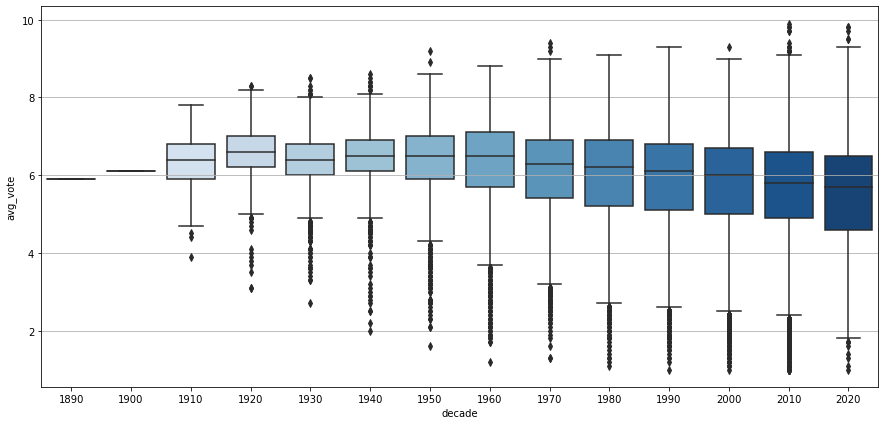

In [101]:
#Boxplot - Notas por Década:
plt.subplots(figsize=(15,7))
plt.grid()  
sns.boxplot(x="decade", y="avg_vote", data=df1,palette="Blues")

In [45]:
#Dados por década
df1.groupby(['decade'])['avg_vote'].describe().round(2)


,count,mean,std,min,25%,50%,75%,max
decade,,,,,,,,
1890,1.0,5.90,NaN,5.9,5.9,5.9,5.9,5.9
1900,1.0,6.10,NaN,6.1,6.1,6.1,6.1,6.1
1910,204.0,6.30,0.65,3.9,5.9,6.4,6.8,7.8
1920,673.0,6.58,0.74,3.1,6.2,6.6,7.0,8.3
1930,2710.0,6.37,0.70,2.7,6.0,6.4,6.8,8.5
1940,2973.0,6.49,0.70,2.0,6.1,6.5,6.9,8.6
1950,4063.0,6.41,0.87,1.6,5.9,6.5,7.0,9.2
1960,4966.0,6.33,1.05,1.2,5.7,6.5,7.1,8.8
1970,6232.0,6.12,1.14,1.3,5.4,6.3,6.9,9.4


<AxesSubplot:xlabel='first_genre', ylabel='avg_vote'>

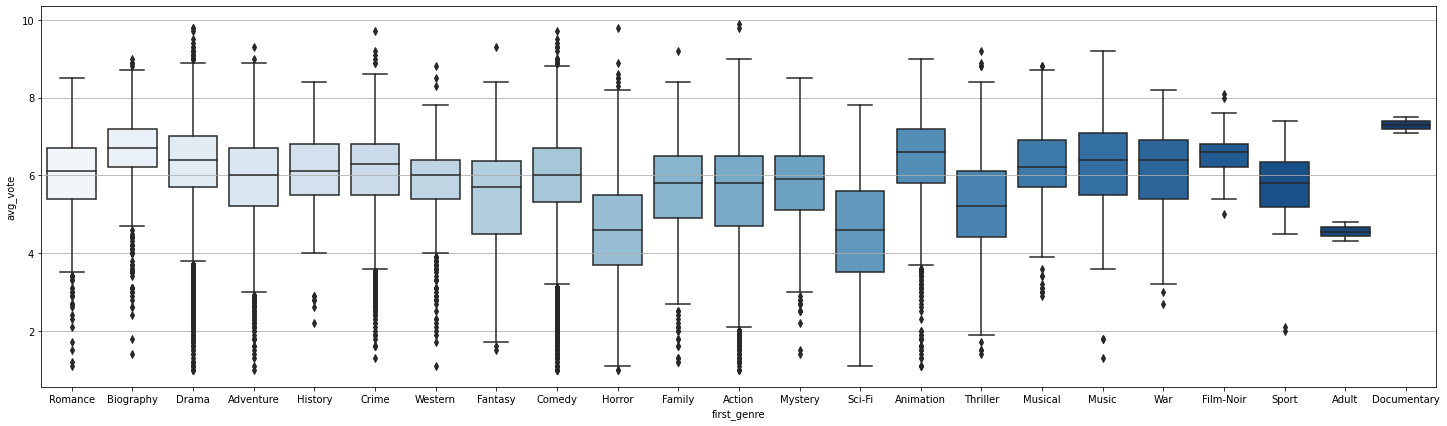

In [100]:
#Boxplot - Notas por Gênero:
plt.subplots(figsize=(25,7))
plt.grid()  
sns.boxplot(x="first_genre", y="avg_vote", data=df1,palette="Blues")

In [93]:
#Dados por Gênero
df_genre_vote=df1.groupby(['first_genre'])['avg_vote'].describe().round(1).sort_values(by=['mean'], ascending=False)
df_genre_vote

,count,mean,std,min,25%,50%,75%,max
first_genre,,,,,,,,
Documentary,2.0,7.3,0.3,7.1,7.2,7.3,7.4,7.5
Film-Noir,29.0,6.6,0.7,5.0,6.2,6.6,6.8,8.1
Biography,2067.0,6.6,0.9,1.4,6.2,6.7,7.2,9.0
Animation,2108.0,6.4,1.2,1.1,5.8,6.6,7.2,9.0
Music,77.0,6.3,1.5,1.3,5.5,6.4,7.1,9.2
Drama,25386.0,6.3,1.0,1.0,5.7,6.4,7.0,9.8
Musical,324.0,6.2,1.0,2.9,5.7,6.2,6.9,8.8
Crime,5557.0,6.1,1.1,1.3,5.5,6.3,6.8,9.7
War,107.0,6.1,1.2,2.7,5.4,6.4,6.9,8.2


<AxesSubplot:xlabel='first_genre', ylabel='avg_vote'>

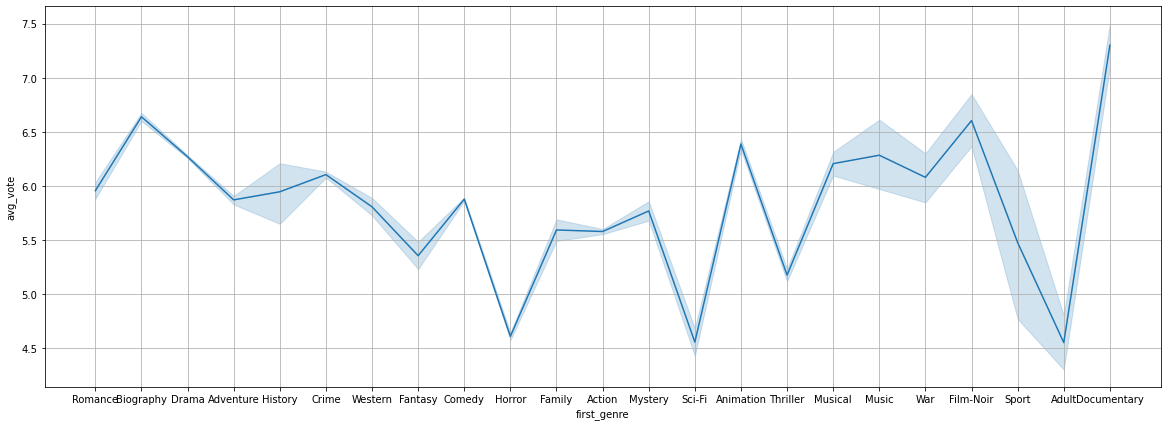

In [130]:
#Nota x Gênero
plt.subplots(figsize=(20,7))
plt.grid()  
sns.lineplot(data=df1, x="first_genre", y="avg_vote",palette="Blues",markers=True,sort= False)

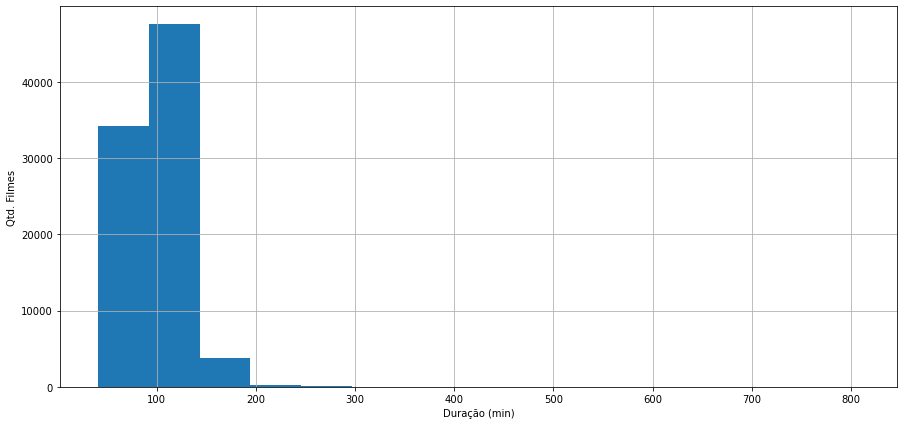

In [115]:
#Duração dos filmes
plt.subplots(figsize=(15,7))
plt.grid()  
#sns.histplot(data=df1,x="duration")
plt.xlabel('Duração (min)')
plt.ylabel('Qtd. Filmes')
plt.hist(df1['duration'], 15, rwidth=1)
plt.show()


In [72]:
#Duração x Gênero
df1.groupby(['first_genre'])['duration'].describe().round(1).sort_values(by=['mean'], ascending=False)

,count,mean,std,min,25%,50%,75%,max
first_genre,,,,,,,,
Biography,2067.0,114.0,25.0,45.0,99.0,110.0,124.0,442.0
History,80.0,109.1,26.7,61.0,93.0,102.5,118.5,205.0
Romance,767.0,108.0,26.9,45.0,90.0,102.0,123.0,278.0
Musical,324.0,107.7,30.3,52.0,88.0,98.5,122.0,247.0
Action,12182.0,107.1,27.7,45.0,90.0,99.0,119.0,421.0
Sport,16.0,105.2,25.2,53.0,89.8,103.0,121.5,165.0
Drama,25386.0,102.9,23.8,45.0,90.0,99.0,111.0,808.0
War,107.0,100.8,20.9,45.0,88.5,98.0,109.5,188.0
Adventure,3599.0,99.1,24.7,45.0,87.0,95.0,106.0,485.0
